# Analysis of M2 in the US

### Importing the relevant libraries

In [275]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Importing the dataset

In [276]:
money = pd.read_csv("M2SL.csv")

### Cleaning the dataset

In [277]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    786 non-null    object 
 1   M2SL    786 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.4+ KB


In [278]:
money["DATE"] = pd.to_datetime(money["DATE"]).copy()

### Plotting the time-series

Text(0, 0.5, 'M2')

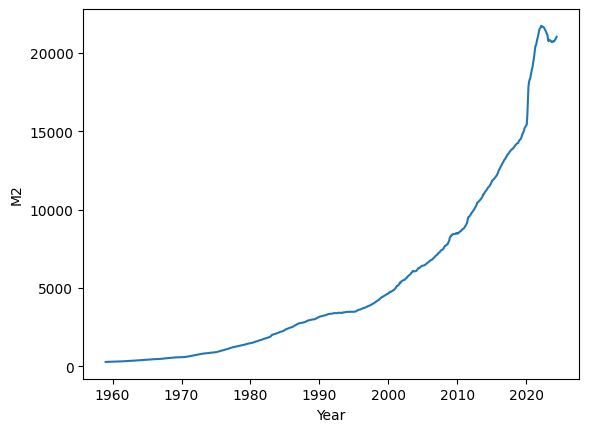

In [279]:
fig, ax = plt.subplots()
ax.plot("DATE", "M2SL", data=money)
ax.set_xlabel("Year")
ax.set_ylabel("M2")

### Testing, if the time-series is stationary

In [280]:
# The time-series is probably not stationary, because mean and variance don't seem to be constant
# Augmented Dickey-Fuller-Test is used for testing

result = adfuller(money["M2SL"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# A p-value which is equal to one is very unlikely but possible due to rounding
# The time-series is non-stationary, because we cannot reject the null-hypothesis

ADF Statistic: 3.434867
p-value: 1.000000
Critical values:
  1% -3.438926964986094
Critical values:
  5% -2.8653254941943174
Critical values:
  10% -2.5687857802554572


### Differencing the time-series

In [281]:
money_diff = money.copy()

money_diff["M2SL"] = money["M2SL"].diff().copy()

### Again testing for non-stationarity

In [282]:
# Drop the row with the missing value
money_diff = money_diff.dropna().copy()

In [283]:
result = adfuller(money_diff["M2SL"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The p-value < 0.05, the time-series is now stationary after differencing for one time
# The time-series is therefore integrated by order 1: I(1)

ADF Statistic: -4.657964
p-value: 0.000101
Critical values:
  1% -3.4388933482333464
Critical values:
  5% -2.8653106782623574
Critical values:
  10% -2.5687778874376086


### Plotting the differenced time-series

Text(0, 0.5, 'M2')

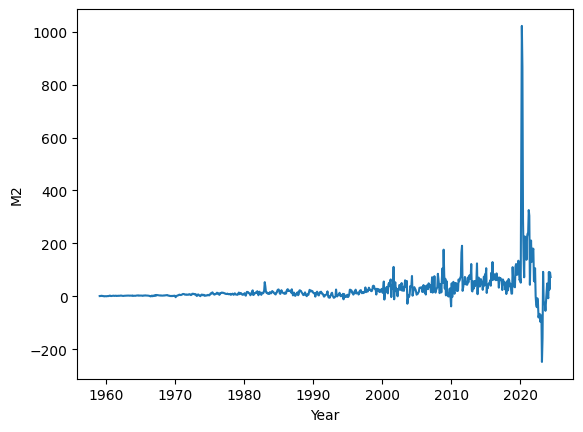

In [284]:
fig, ax = plt.subplots()
ax.plot("DATE", "M2SL", data=money_diff)
ax.set_xlabel("Year")
ax.set_ylabel("M2")

# It is visible, that around 2020 there has been a big increase in the growth-rate of M2, which is probably connected to the COVID-19 pandemic
# Government intervened and tried to keep the american economy from collapsing (this hypothesis is a good topic for future projects)

# Because the original time-series is non-stationary, an ARIMA-model would be a fitting model...

### Using information criteria (Schwarz criterium) to find the optimal number of lags for the model

In [285]:
money_diff = money_diff.set_index("DATE").copy()

In [286]:
# The frequency for the time has to be set
money_diff = money_diff.asfreq("MS")

In [287]:
# First, we'll determine the optimum amount of lags for the AR-model

bic_value_1 = []

for p in range(1, 31):
    ARmodel = AutoReg(money_diff["M2SL"], lags=p).fit()
    bic = ARmodel.bic
    bic_value_1.append(bic)


ARbic = pd.DataFrame({"BIC": [item for item in bic_value_1]})

ARbic.min()

# The BIC-criterium is getting smaller with increasing number of lags without stopping
# Because of this problem, the ACF and PACF are being used to determine the number of lags

BIC    7860.975055
dtype: float64

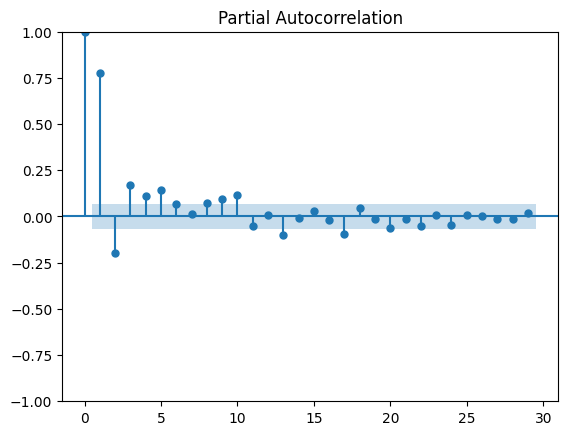

In [288]:
plot_pacf(money_diff["M2SL"])
plt.show()

# After the third lag, the partial autocorrelation seems to almost fall under the confidence bands
# Therefore, 3 lags should be sufficient for the AR-model

In [299]:
# Secondly, we'll determine the optimum amount of lags for the AR-model

bic_value_2 = []

for q in range(1, 21):
    MAmodel = ARIMA(money_diff["M2SL"], order=(0, 0, q)).fit()
    bic = MAmodel.bic
    bic_value_2.append(bic)


MAbic = pd.DataFrame({"BIC": [item for item in bic_value_2]})

print(f"The optimal amount of lags for the MA-model is: {MAbic.idxmin() + 1} lags.")

The optimal amount of lags for the MA-model is: BIC    13
dtype: int64 lags.


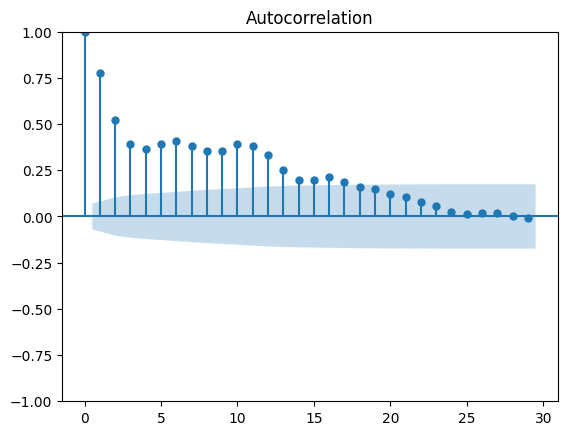

In [ ]:
plot_acf(money_diff["M2SL"])
plt.show()

# After lag 12, the autocorrelation starts to go near insignificance
# Therefore 12 lags are sufficient for the MA-model
# This is in line with the BIC-value